# 정리
1. 몇 가지 기준으로 대상이 될 종목들을 가져온다
    - 시점 (매수 시점)에 따른 시가총액, 우선주 제외
2. change table에서 이 종목들의 대상 기간에 대한 가격정보를 가져온다
    - 대상 기간 (매수 고려 시점 : 매수 시점 - x개월) 에서의 누적 수익률을 계산한다.
3. 누적 수익률을 기준으로 종목을 분류한다.
4. 이를 반복하여 momentum 지표를 확인한다.

In [1]:
import pandas as pd
import FinanceDataReader as fdr

In [2]:
def date_str_bar (date):
    date_temp=str("%s-%02d-%02d" %(date.year, date.month, date.day))
    return date_temp
def date_str (date):
    date_temp=str("%s%02d%02d" %(date.year, date.month, date.day))
    return date_temp

## 자료 불러오기

In [3]:
change_all = pd.read_csv('Raw_Price/change_all.csv',index_col=0)

## 대상 종목 선정하기

In [4]:
# 시가총액에 따라 정제하기
from pykrx import stock
import re
from datetime import datetime

# 특정 시점에 시가총액, 거래대금 기준으로 대상이 되는 종목 list up
def make_stock_list_by_date (date : datetime, cap : int=10000000000,trade : int=100000000)->list:
    date = date_str(date)
    df_cap_kospi = stock.get_market_cap_by_ticker(date,market='KOSPI')
    df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
    df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
    
    df_cap = df_cap[lambda df_cap : df_cap['시가총액'] > np.int64(cap)] #시가총액 100억 이상
    df_cap = df_cap[lambda df_cap : df_cap['거래대금'] > np.int64(trade)] #거래대금 1억 이상
    total_list = df_cap.index
    list_temp=[]
    p=re.compile('[0-9]*5$|[0-9]*7$|[0-9]*9$|[0-9]*K$|[0-9]*L$|[0-9]*M$|[0-9]*B$')
    for i in total_list:
        if not p.match(i):
            list_temp.append(i)
    return list_temp

In [189]:
def make_stock_list_by_date_cap (date : datetime, cap : int=10000000000,trade : int=100000000)->list:
    date = date_str(date)
    df_cap_kospi = stock.get_market_cap_by_ticker(date,market='KOSPI')
    df_cap_kosdaq = stock.get_market_cap_by_ticker(date, market='KOSDAQ')
    df_cap = pd.concat([df_cap_kospi,df_cap_kosdaq], axis=0)
    
    df_cap = df_cap[lambda df_cap : df_cap['시가총액'] > np.int64(cap)] #시가총액 100억 이상
    df_cap = df_cap[lambda df_cap : df_cap['거래대금'] > np.int64(trade)] #거래대금 1억 이상
    df_cap = df_cap.sort_values(by='시가총액',ascending=False) #시가총액 높은게 먼저
    total_list = df_cap.index
    list_temp=[]
    p=re.compile('[0-9]*5$|[0-9]*7$|[0-9]*9$|[0-9]*K$|[0-9]*L$|[0-9]*M$|[0-9]*B$')
    for i in total_list:
        if not p.match(i):
            list_temp.append(i)
    return list_temp

In [9]:
# 대상 종목을 대상 기간동안의 수익률 기준으로 오름차순 정렬
def make_stock_list_by_yield (stocks : list, bgn : datetime, end : datetime) -> list:
    change_stocks = change[stocks]
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_stocks = yield_stocks.dropna(axis=1) #그 기간 중 상장한 경우 결측치로 나와 결측치를 제거함.
    stock_list = yield_stocks.T.sort_values(by=yield_stocks.index[0],ascending=True)
    return stock_list.index

In [153]:
#ID (정보이산) = sign(과거수익률) x [마이너스 수익률 비중(%)-플러스 수익률 비중(%)]
def make_stock_list_by_discrete (stocks : list, bgn : datetime, end : datetime) -> list:
    change_stocks = change[stocks]
    # sign(PERT) 를 계산하는 것은 2m-12m
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_stocks = yield_stocks.dropna(axis=1) #그 기간 중 상장한 경우 결측치로 나와 결측치를 제거함.
    sign_stocks = yield_stocks.T[yield_stocks.index[0]].apply(lambda x:1 if x>1 else -1)
    
    # %neg-%pos 를 계산하는 것은 1m-12m (?) -> 아직은 2m-12m으로 함수구성됨.
    yield_count = change[yield_stocks.columns].loc[date_str_bar(bgn):date_str_bar(end),:]
    for i in yield_count.columns:
        yield_count[i] = yield_count[i].apply(lambda x: -1 if x>0 else 1)
    yield_count = yield_count.sum(axis=0)
    
    yield_id = pd.concat([pd.DataFrame(sign_stocks) ,pd.DataFrame(yield_count)],axis=1)
    yield_id['ID'] = yield_id[yield_id.columns[0]]*yield_id[yield_id.columns[1]]/len(yield_stocks.columns)
    stock_list = yield_id.sort_values(by='ID',ascending=False)
    return stock_list.index

## 대상기간의 가격정보 가져오기

In [86]:
from dateutil.relativedelta import relativedelta

In [6]:
def cal_yield_by_stock(stocks : list, bgn : datetime, end : datetime) -> float:
    change_stocks = change[stocks]
    yield_stocks = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().tail(1)
    yield_sum = (yield_stocks.T.sum() / len(stocks)).values[0]
    return yield_sum

In [87]:
def cal_yield_by_stock_daily(stocks : list, bgn : datetime, end : datetime) :
    change_stocks = change[stocks]
    yield_sum = (change_stocks.loc[date_str_bar(bgn):date_str_bar(end),:]+1).cumprod().sum(axis=1)/len(stocks)
    yield_list_temp = []
    yield_list_temp.append(yield_sum.values[0])
    for i in range(len(yield_sum.values)-1):
        yield_list_temp.append(yield_sum.values[i+1] / yield_sum.values[i])
    
#     yield_sum = (yield_stocks.T.sum() / len(stocks)).values[0]
    return pd.DataFrame(data=yield_list_temp,index=yield_sum.index)

## 기간에 따른 수익률 정보 취합하기

In [191]:
buy = datetime(2010,1,1)
momen = 5
gap = 1
duration_stock_estimation = 11
duration_stock_selection = 3
duration_trade = 1 #매월 rebalancing
discrete = 3
cap = 3

In [135]:
# Momentum 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    stock_list = make_stock_list_by_date(buy)
    stock_list_by_yield = make_stock_list_by_yield(stock_list, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                   end=buy-relativedelta(months = gap))
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
        df_yield_partial = pd.DataFrame()
        # momentum기준으로 나눈 그룹마다 계산
        for k in range(momen):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(momen)*k):int(len(stock_list_by_yield)/(momen)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'Low',4:'High'},inplace=True)

The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX changes the date parameter to 20111229 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX cha

In [195]:
# 시가총액 + Momentum 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    # 시가총액기준 & 시가총액 높은것부터 정렬
    stock_list_by_cap = make_stock_list_by_date_cap(buy)
    # Momentum 지표 낮은것부터 정렬
    stock_list_by_yield = []
    for part in range(cap):
        stock_list_temp_partial = stock_list_by_cap[int(len(stock_list_by_cap)/cap*part):int(len(stock_list_by_cap)/cap*(part+1))]
        stock_list_temp_partial = make_stock_list_by_yield(stock_list_temp_partial, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                          end=buy-relativedelta(months = gap))
        stock_list_by_yield = stock_list_by_yield + list(stock_list_temp_partial)
    
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
        df_yield_partial = pd.DataFrame()
        for k in range(cap*momen):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(cap*momen)*k):int(len(stock_list_by_yield)/(cap*momen)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'High Cap Low Momen',4:'High Cap High Momen',10:'Low Cap Low Momen',14:'Low Cap High Momen'},inplace=True)

The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX changes the date parameter to 20111229 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX cha

In [168]:
# Momentum 지표 + discrete 지표 사용
start = datetime(2010,1,1)
change = change_all
df_yield = pd.DataFrame()
for i in range(50):
    buy = start + relativedelta(months=duration_stock_selection*i)
#     print(buy)
    if buy > datetime(2021,6,1):
        break
    stock_list = make_stock_list_by_date(buy)
    stock_list_by_yield = make_stock_list_by_yield(stock_list, bgn=buy-relativedelta(months = gap+duration_stock_estimation),
                                                   end=buy-relativedelta(months = gap))
    # partial로 구분된 stock_list를 각각 discrete기준으로 재정렬
    stock_list_by_yield_discrete = []
    for part in range(momen):
        stock_list_temp_partial = stock_list_by_yield[int(len(stock_list_by_yield)/momen*part):int(len(stock_list_by_yield)/momen*(part+1))]
        stock_list_temp_partial = make_stock_list_by_discrete(stock_list_temp_partial, bgn=buy-relativedelta(months = gap+duration_stock_estimation), 
                                                              end=buy-relativedelta(months = gap))
        stock_list_by_yield_discrete = stock_list_by_yield_discrete + list(stock_list_temp_partial)
    stock_list_by_yield = stock_list_by_yield_discrete
    
    #rebalancing
    for j in range(int(duration_stock_selection/duration_trade)):
        buy_rebal = buy + relativedelta(months=j)
#         yield_list = []
        df_yield_partial = pd.DataFrame()
        for k in range(momen*discrete):
            stock_list_temp = stock_list_by_yield[int(len(stock_list_by_yield)/(momen*discrete)*k):int(len(stock_list_by_yield)/(momen*discrete)*(k+1))]
            # rebalance할때마다가 아닌 daily기준으로 수익률 data를 넣기
            df_yield_temp_partial = cal_yield_by_stock_daily(stocks=stock_list_temp,bgn=buy_rebal,end=buy_rebal+relativedelta(months = duration_trade))
            df_yield_temp_partial.rename(columns={0:k},inplace=True)
            df_yield_partial = pd.concat([df_yield_partial,df_yield_temp_partial],axis=1)
        df_yield_temp = df_yield_partial
        df_yield = pd.concat([df_yield,df_yield_temp],axis=0)
df_yield.rename(columns={0:'Low_Discrete',2:'Low_Continuous',12:'High_Discrete',14:'High_Continuous'},inplace=True)

The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20100101 seems to be a holiday. PYKRX changes the date parameter to 20091230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20110101 seems to be a holiday. PYKRX changes the date parameter to 20101230 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20111001 seems to be a holiday. PYKRX changes the date parameter to 20110930 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX changes the date parameter to 20111229 to query the requested information.
The date you entered 20120101 seems to be a holiday. PYKRX cha

In [196]:
# 리밸런싱하는 시점은 이전과 이후 두번이 계산되기 때문에, df_yield의 index에서 중복으로 입력되어있다.
# 리벌랜싱 이후만을 사용하기 위해 중복 중에 마지막 것만 사용한다.
# df_yield.groupby(df_yield.index).first()
df_yield = df_yield.groupby(df_yield.index).last()

In [ ]:
df_yield.to_csv('Product/Momentum_Cap_5partial_11m_est_w_1m_gap_3m_selec_1m_rebal.csv')

# 누적 그래프 작성

In [239]:
import matplotlib.pyplot as plt
import matplotlib.dates as md

In [244]:
def date_to_date (date):
    date = date.split('-')
    date_new = datetime(int(date[0]),int(date[1]),int(date[2]))
    return date_new

In [245]:
df_yield.index = [date_to_date(date) for date in df_yield.index ]

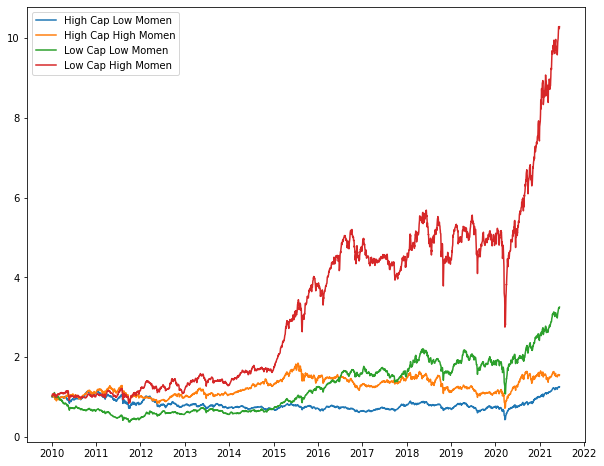

In [254]:
to_show = ['High Cap Low Momen','High Cap High Momen','Low Cap Low Momen','Low Cap High Momen']
fig, ax = plt.subplots(1,1,figsize=(10,8))
for i in range(len(to_show)):
    ax.plot(df_yield.cumprod()[to_show[i]])
ax.xaxis.set_major_locator(md.YearLocator(1,month=1,day=1))
ax.xaxis.set_major_formatter(md.DateFormatter('%Y'))
plt.legend(to_show)
plt.show()

기타코드

In [ ]:
# 우선주 등 제외하기
# stock_code_list 정제하기 (우선주, 리츠, 옵션) -> 6자리 숫자만, 맨 앞자리에 0 들어가는 것만
import re
stock_code_list = []
for stock_code in df_cap.index:
    stock_code = re.findall("\d+", stock_code)[0] # 숫자만 추출한 뒤 첫번째 것만 사용
    if (stock_code[-1] == '0') and (len(stock_code) == 6):
        stock_code_list.append(stock_code)
len(stock_code_list)

In [ ]:
from collections import Counter
a = Counter(df_yield.index.to_list())
a.most_common()

In [ ]:
df_yield[df_yield.index == '2010-02-01']